![alt text](https://www.msengineering.ch/typo3conf/ext/msengineering/Resources/Public/Images/Logo/mse-full.svg "MSE Logo") 

# AnTeDe Practical Work 8: Name Generation with RNN

by Fabian Märki


Solved by:
* Matthias Egli

## Summary
The aim of this lab is to get an understanding of building a RNN model using Keras. The task is to train a character-level language models that generates new baby names (but feel free to change this to e.g. new start-up names or city names etc.). 

### Source
- https://github.com/JKH4/name-generator/blob/master/dev/2018-05-18_JKH_NameGen-Main.ipynb

This lab contains assigments (although most of the code is given). <font color='green'>Questions are written in green.</font>

In [94]:
from __future__ import print_function
import numpy as np
import pandas as pd
import random
import sys
import io
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import json

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, InputLayer

from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from more_itertools import sort_together

In [41]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    print("Run on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #config.gpu_options.per_process_gpu_memory_fraction = 0.4

Run on GPU


### Your Task

Below you find working code, most of it does not need your attention and can be used as is (e.g. `load_data`).

Your task is to get hands on experience with Keras and RNNs by trying different options on how to build a RNN and on how to tune it. 
<font color='green'><br>After you created a model with good performance, please write a short summary about your experience: what works well, what did not work well, what influenced the performance of the model, did you experience strange behaviors, how did you analyze the data, how do you estimate the performance of your model, what possible further improvements you can consider.</font>

<font color='green'>Modify the function `create_model` </font>according your intuition on how the model could be improved. Options you might want to try (please experiment with at least four of them):
- try different RNN types (SimpleRNN, LSTM, GRU - see [here](https://keras.io/layers/recurrent))
- try different number of RNN units (see `parameters`)
- use regularization techniques (e.g. dropout)
- use options provided by the RNN types (e.g. arguments "dropout" and "recurrent_dropout" - see [here](https://keras.io/layers/recurrent))
- stack several RNN layers (see [here](https://keras.io/getting-started/sequential-model-guide/) and search for "Stacked LSTM for sequence classification")
- try different optimizers (see [here](https://keras.io/optimizers/))
- get more inspiration from [here](https://ruder.io/deep-learning-nlp-best-practices)

<font color='green'>You might also want to have a look at the `parameters` variable below and modify it according your needs.</font> 

### What works well
Application of most of the code worked well.

### What did not work well
Could not print the confusion matrix with the given implementation in reasonable time.


### What influenced the performance of the model
* Number of neurons, layers, type of recurrent nodes, learning rate
* Frankly everything that can be tuned has an effect on the performance in some way or another


### Strange behaviors
Nothing strange experienced


### How I analyzed the data
* Looking at random samples
* Looking at the balance


### How I estimated the performance of the model
* I created a test split that allows to check the quality of the model, in regard to generalization.
* By looking at the learning curves
* By looking at the generated names I could get a feeling about the performance of the model.

### What further improvements to consider
* Longer training
* Higher complexity in general
* Application of attention mechanism in some way
* Better tuning of hyperparams in general

<font color='green'>Please provide a summary of your experience right here.</font>

## Provided code

In [91]:
def create_model(parameters):
    # length of string to be used for training and predicting next chars
    length_of_sequence = parameters["trainset_infos"]['length_of_sequence']
    # size of vocabulary read from parameter file (see below)
    number_of_chars = parameters["trainset_infos"]['number_of_chars']
    
    model = Sequential()
    model.add(InputLayer(input_shape=(length_of_sequence, number_of_chars)))
    if parameters['rnn_kind'] == 'SimpleRNN':
      model.add(SimpleRNN(parameters["rnn_units"]))
    elif parameters['rnn_kind'] == 'LSTM':
      model.add(LSTM(parameters["rnn_units"]))
    elif parameters['rnn_kind'] == 'GRU':
      model.add(GRU(parameters["rnn_units"]))
    model.add(Dropout(0.1))
    model.add(Dense(number_of_chars, activation='softmax'))
    
    if parameters.get("verbose"):
        model.summary()
        
    return model

def load_data(parameters):
    length_of_sequence = 5
    padding_start = '#'
    padding_end = '*'
    file_url = parameters["file_url"]

    text = ''
    with io.open(get_file(os.path.basename(file_url), origin=file_url), encoding='utf-8') as f:
        text = f.read().lower()

    names = pd.read_csv(io.StringIO(text), names=['name'], comment='#', header=None, keep_default_na=False, na_values=[])
    names['name'] = names['name'].map(lambda n: n.replace(padding_start, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: n.replace(padding_end, ''))    # replace characters used for training
    names['name'] = names['name'].map(lambda n: padding_start + n + padding_end) 
    
    data_dict = {}
    data_dict['name_list'] = names['name']
    data_dict['char_list'] = sorted(list(set(data_dict['name_list'].str.cat() + '*')))
    data_dict['char_to_ix'] = { ch:i for i,ch in enumerate(data_dict['char_list']) }
    data_dict['ix_to_char'] = { i:ch for i,ch in enumerate(data_dict['char_list']) }
           
    # Extract target names to list (currently '#name*')
    training_names = data_dict['name_list'].tolist()
    
    # Extract padding characters
    padding_start = training_names[0][0]
    padding_end = training_names[0][-1]

    # Extract target character convertors
    # This will be used to convert a character to its "one hot index" and vice versa (cf Keras to_categorical())
    c2i = data_dict['char_to_ix']
    i2c = data_dict['ix_to_char']
    
    # Extract the target number of characters in all target names
    # This will be used to convert character index in its "one hot" representation (cf Keras to_categorical())
    number_of_chars = len(data_dict['char_list'])
    # Pad target names with enough (lengh_of_sequence) padding characters (result '##...##name**...**' )
    # The goal is  be sure that, for each name, the first training data is X[0] = '##...##'
    # and Y[0] = First actual character of the name
    training_names = [
        padding_start * (length_of_sequence - 1) + n + padding_end * (length_of_sequence - 1) for n in training_names
    ]

    # Init X and Y as list
    X_list = []
    Y_list = []

    # Init counter for visual feedback
    counter = 0 if parameters["verbose"] else None
    
    for name in training_names:
        # Slide a window on the name, one character at a time
        for i in range(max(1, len(name) - length_of_sequence)):
            # Extract the new sequence and the character following this sequence
            new_sequence = name[i:i + length_of_sequence]
            target_char = name[i + length_of_sequence]
            
            # Add the new sequence to X (input of the model)
            X_list.append([to_categorical(c2i[c], number_of_chars) for c in new_sequence])
            # Add the following character to Y (target to be predicted by the model)
            Y_list.append(to_categorical(c2i[target_char], number_of_chars))
        
        # visual feedback
        if parameters["verbose"]:
            counter += 1
            print(counter) if counter % 100 == 0 else print('.', end='')
            
    # make sure number of elements allignes with batch size
    offset = len(X_list) % parameters["batch_size"]
    if offset != 0:
        elements_to_copy = parameters["batch_size"] - offset
        X_list.extend(X_list[:elements_to_copy])
        Y_list.extend(Y_list[:elements_to_copy])
        
    # Convert X and Y to numpy array
    x_train = np.array(X_list)
    y_train = np.array(Y_list)

    from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

    parameters['x_train'] = x_train
    parameters['x_test'] = x_test
    parameters['y_train'] = y_train
    parameters['y_test'] = y_test
    
    # Extract the number of training samples
    m = len(x_train)
    
    # Create a description of the trainset
    parameters["trainset_infos"] = {
        'length_of_sequence': length_of_sequence,
        'number_of_chars': number_of_chars,
        'm': m,
        'padding_start': padding_start,
        'padding_end': padding_end,
    }

    print(
        '\n{} names split in {} training sequence of {} encoded chars !'.format(counter, m, length_of_sequence)
    ) if parameters["verbose"] else None

    # Visual feedbacks
    if parameters["verbose"]:
        print('X shape: {}'.format(x_train.shape))
        print('Y shape: {}'.format(y_train.shape))

        print('X[0] = {}'.format(x_train[0]))
        print('Y[0] = {}'.format(y_train[0]))

        print('Training set size: {}'.format(m))
        print('length_of_sequence: {}'.format(length_of_sequence))
        print('number_of_chars: {}'.format(number_of_chars))
        print('some names: {}'.format(names['name'][:5]))
    
                 
    parameters["x_train"] = x_train
    parameters["y_train"] = y_train
    parameters["word2index"] = c2i
    parameters["index2word"] = i2c                


def compile_model(model, parameters):
    if parameters['optimizer'] == "adam":
      optimizer = Adam(learning_rate = parameters["learning_rates"][parameters["iter"]])
    elif parameters['optimizer'] == "sgd":
      optimizer = SGD(learning_rate = parameters["learning_rates"][parameters["iter"]])
    elif parameters['optimizer'] == "rmsprop":
      optimizer = RMSprop(learning_rate = parameters["learning_rates"][parameters["iter"]])

    model.compile(loss=parameters["loss_function"], optimizer=optimizer, metrics = parameters["metrics"])

        
def train_model(model, parameters):
    i = parameters["iter"]
    
    # Train the model
    h = model.fit(
        parameters["x_train"], parameters["y_train"],
        validation_data = (parameters["x_test"], parameters["y_test"]),
        batch_size = parameters["batch_size"],
        callbacks = parameters.get("callbacks"),
        initial_epoch = parameters["total_epochs"],
        epochs = parameters["total_epochs"] + parameters["epochs_to_run"][i]
    )

    history = parameters["history"]
    # Update history
    for key, val in h.history.items():
        col = history.get(key)
        
        if col is None:
            col = np.array([])
        
        history[key] = np.append(col, val)
        
    
    # Update the training session info
    parameters['total_epochs'] += parameters['epochs_to_run'][i]
    
    
def plot_class_balance(y, title=''):
    (unique, counts) = np.unique(y, return_counts=True)
    (unique, counts) = sort_together([unique, counts])

    plt.bar(unique, counts, align='center')
    plt.xticks(np.arange(len(unique)), unique)
    plt.xlabel('label')
    plt.ylabel('count')
    plt.title(title)

    plt.show()
    
    
def plot_confusion_matrix(y_true, y_pred, title=''):
    classes = list(set(list(y_true) + list(y_pred)))
    classes.sort()

    cmm = confusion_matrix(y_true, y_pred)

    print(cmm)

    print('Set Population: {}'.format(cmm.sum()))
    print('Accuracy: {:.4f}'.format(float(cmm.trace()) / cmm.sum()))

    plt.figure(figsize=(10, 8))
    plt.imshow(cmm / cmm.sum(), interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()

    plt.ylim(-0.5, len(classes)-0.5)

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, size='x-large')
        plt.yticks(tick_marks, classes, size='x-large')

    for y in range(cmm.shape[0]):
        for x in range(cmm.shape[1]):
            if cmm[y, x] > 0:
                plt.text(x, y, '%.0i' % cmm[y, x],
                         horizontalalignment='center',
                         verticalalignment='center')
    plt.show()
    

def plot_training_session(parameters, plots=["accuracy", "val_accuracy"]):
    history = parameters["history"]
    
    x = range(len(history[plots[0]]))
    
    for label in plots:
        vals = history.get(label)
        if vals is not None:
            plt.plot(x, vals, label = label)
        else:
            print("There is no data for", label)
    
    plt.xlabel('epoch')
    plt.title('Progress')
    plt.legend()
    plt.show()
    
def generate_name(model, parameters, start_char = None, name_max_length = 25):
    '''
    Generate some name with the RNN model
    
    ## Inputs:
    model (Keras model): 
    parameters (dict): the parameters
    name_max_length (integer): max size of the generated name
    verbose (boolean): show some feedbacks
    ## Outputs:
    generated_name (string): name generated by the RNN
    (probability, gap): few numbers about this generated name
        probability: probability to generate this name (cummulative probability to select each character)
        ecart: gap between best name and this name (cummulative sum of gaps between selected character and best character)
        
    '''
    trainset_infos = parameters["trainset_infos"]
    # Extract the number of unique character in trainset
    dict_size = trainset_infos["number_of_chars"]
    
    # Extract the size of an input sequence
    sequence_length = trainset_infos["length_of_sequence"]
    
    # Extract utils dictionnary to convert character to one hot index and vice versa
    # in this context 'word' is meant to be a character
    i2c = parameters["index2word"]
    c2i = parameters["word2index"]
    
    # Extract padding character
    padding_start = trainset_infos["padding_start"]
    
    # Init a name full of padding_start character
    generated_name = padding_start * (sequence_length + name_max_length)

    # Init counters
    probability = 1
    gap = 0

    if start_char is not None:
        generated_name = generated_name[:(sequence_length - 1)] + start_char + generated_name[sequence_length:]
    
    # Generate new character from current sequence
    for i in range(name_max_length):
        # Extract current sequence from generated character
        x_char = generated_name[i:i+sequence_length]
        
        # Convert current sequence to one hot vector
        x_cat = np.array([[to_categorical(c2i[c], dict_size) for c in x_char]])
        
        # Predict new character probabilities
        # Actually this output a list of probabilities for each character
        p = model.predict(x_cat)

        # Extract the best character (and its probability)
        best_char = i2c[np.argmax(p)]
        best_char_prob = np.max(p)

        # Choose a random character index according to their probabilities (and its probability)
        new_char_index = np.random.choice(range(dict_size), p = p.ravel())
        new_char_prob = p[0][new_char_index]
        
        # Convert the index to an actual character
        new_char = i2c[new_char_index]
                
        # Update the generated name with the new character
        generated_name = generated_name[:sequence_length+i] + new_char + generated_name[sequence_length+i+1:]
        
        # Update counters
        probability *= new_char_prob # probabilities are multiplied
        gap += best_char_prob-new_char_prob # gaps are summed

        # Show some feedbacks
        if parameters["verbose"]:
            print(
                'i={} new_char: {} ({:.3f}) [best:  {} ({:.3f}), diff: {:.3f}, prob: {:.3f}, gap: {:.3f}]'.format(
                    i,
                    new_char,
                    new_char_prob,
                    best_char,
                    best_char_prob,
                    best_char_prob-new_char_prob,
                    probability,
                    gap
                )
            )

        # Stop the prediction loop if it reached a 'padding_end' character
        if (new_char == trainset_infos['padding_end']):
            break
    
    # Clean the generated name
    generated_name = generated_name.strip('#*')
    
    # Show some feedbacks
    print('{} (probs: {:.6f}, gap: {:.6f})'.format(generated_name, probability, gap)) if parameters["verbose"] else None

    return generated_name, {'probability': probability, 'gap': gap}

<font color='green'>You will need to tune the parameters (you probably want to have a look at 'rnn_units', and 'epochs_to_run').  Please indicate as comments the values you tried, and the best values you keep.</font>

In [43]:
parameters = {
    "verbose": True,
    "rnn_units": 16,
    "iter": 0,
    "epochs_to_run": [8],
    "learning_rates": [0.003],
    "total_epochs": 0,
    "loss_function": "categorical_crossentropy", 
    "metrics": ["accuracy"],
    "batch_size": 32,
    "history": {},
    #"file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt"
    "file_url": "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/female.txt"
}

load_data(parameters)

## Utilities

In [ ]:
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime() -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start

## Data analysis

            name
579     #darren*
242      #barry*
2516   #tedmund*
2538   #thaddus*
1643  #martainn*
2301       #see*
2824     #wiley*
1066    #hakeem*
158       #arel*
389   #caldwell*
Has duplicates: False
             name
1197    #horatio*
210        #axel*
2144    #rinaldo*
2775    #waverly*
314      #bishop*
1768     #morris*
164      #armand*
1001    #giraldo*
49     #alasdair*
2248  #salvatore*
Has duplicates: False


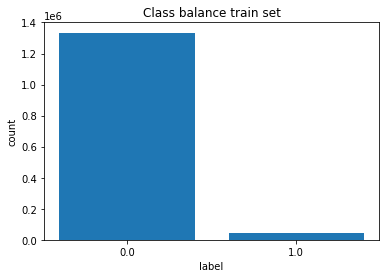

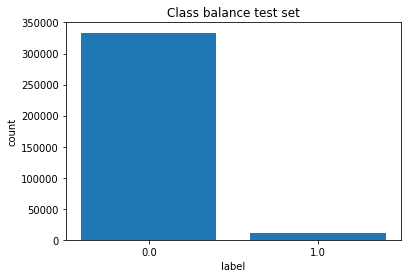

In [106]:
length_of_sequence = 5
padding_start = '#'
padding_end = '*'
file_url = "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt"

text = ''
with io.open(get_file(os.path.basename(file_url), origin=file_url), encoding='utf-8') as f:
    text = f.read().lower()

names = pd.read_csv(io.StringIO(text), names=['name'], comment='#', header=None, keep_default_na=False, na_values=[])
names['name'] = names['name'].map(lambda n: n.replace(padding_start, ''))    # replace characters used for training
names['name'] = names['name'].map(lambda n: n.replace(padding_end, ''))    # replace characters used for training
names['name'] = names['name'].map(lambda n: padding_start + n + padding_end)
print(names.sample(n=10))
print(f"Has duplicates: {names.duplicated().any()}")

file_url = "https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/male.txt"

text = ''
with io.open(get_file(os.path.basename(file_url), origin=file_url), encoding='utf-8') as f:
    text = f.read().lower()

names = pd.read_csv(io.StringIO(text), names=['name'], comment='#', header=None, keep_default_na=False, na_values=[])
names['name'] = names['name'].map(lambda n: n.replace(padding_start, ''))    # replace characters used for training
names['name'] = names['name'].map(lambda n: n.replace(padding_end, ''))    # replace characters used for training
names['name'] = names['name'].map(lambda n: padding_start + n + padding_end)
print(names.sample(n=10))
print(f"Has duplicates: {names.duplicated().any()}")


plot_class_balance(parameters["y_train"], title='Class balance train set')
plot_class_balance(parameters["y_test"], title='Class balance test set')

## Different RNN Types

############################## SimpleRNN ##############################
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 32)                2048      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 31)                1023      
                                                                 
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1390/1390 [==============================] - 11s 7ms/step - loss: 1.6733 - accuracy: 0.5144 - val_loss: 1.4747 - val_accuracy: 0.5405
Epoch 2/20
1390/1390 [==============================] - 14s 10ms/step - loss: 1.4352 - accuracy: 0

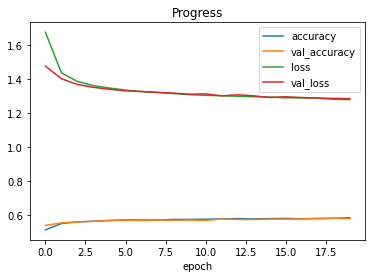

i=0 new_char: o (0.278) [best:  a (0.287), diff: 0.009, prob: 0.278, gap: 0.009]
i=1 new_char: r (0.122) [best:  n (0.199), diff: 0.077, prob: 0.034, gap: 0.086]
i=2 new_char: i (0.426) [best:  i (0.426), diff: 0.000, prob: 0.014, gap: 0.086]
i=3 new_char: e (0.166) [best:  n (0.174), diff: 0.009, prob: 0.002, gap: 0.095]
i=4 new_char: * (0.499) [best:  * (0.499), diff: 0.000, prob: 0.001, gap: 0.095]
jorie (probs: 0.001192, gap: 0.094845)
('jorie', {'probability': 0.0011918791007694638, 'gap': 0.0948454737663269})
i=0 new_char: a (0.087) [best:  c (0.119), diff: 0.032, prob: 0.087, gap: 0.032]
i=1 new_char: n (0.175) [best:  l (0.186), diff: 0.010, prob: 0.015, gap: 0.043]
i=2 new_char: d (0.251) [best:  d (0.251), diff: 0.000, prob: 0.004, gap: 0.043]
i=3 new_char: e (0.298) [best:  e (0.298), diff: 0.000, prob: 0.001, gap: 0.043]
i=4 new_char: a (0.056) [best:  l (0.442), diff: 0.387, prob: 0.000, gap: 0.430]
i=5 new_char: n (0.083) [best:  * (0.851), diff: 0.768, prob: 0.000, gap: 

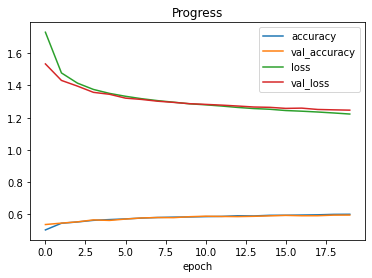

i=0 new_char: u (0.097) [best:  o (0.334), diff: 0.237, prob: 0.097, gap: 0.237]
i=1 new_char: b (0.018) [best:  l (0.233), diff: 0.214, prob: 0.002, gap: 0.452]
i=2 new_char: e (0.297) [best:  i (0.438), diff: 0.141, prob: 0.001, gap: 0.593]
i=3 new_char: n (0.086) [best:  t (0.258), diff: 0.172, prob: 0.000, gap: 0.765]
i=4 new_char: * (0.124) [best:  a (0.290), diff: 0.167, prob: 0.000, gap: 0.931]
juben (probs: 0.000006, gap: 0.931356)
('juben', {'probability': 5.5813420531030875e-06, 'gap': 0.9313564151525497})
i=0 new_char: j (0.054) [best:  c (0.114), diff: 0.061, prob: 0.054, gap: 0.061]
i=1 new_char: a (0.238) [best:  o (0.334), diff: 0.097, prob: 0.013, gap: 0.158]
i=2 new_char: r (0.029) [best:  n (0.337), diff: 0.308, prob: 0.000, gap: 0.466]
i=3 new_char: i (0.310) [best:  i (0.310), diff: 0.000, prob: 0.000, gap: 0.466]
i=4 new_char: e (0.141) [best:  n (0.206), diff: 0.065, prob: 0.000, gap: 0.531]
i=5 new_char: * (0.626) [best:  * (0.626), diff: 0.000, prob: 0.000, gap:

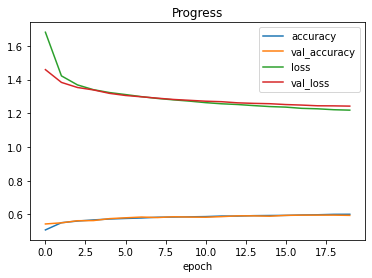

i=0 new_char: o (0.333) [best:  o (0.333), diff: 0.000, prob: 0.333, gap: 0.000]
i=1 new_char: t (0.009) [best:  l (0.185), diff: 0.176, prob: 0.003, gap: 0.176]
i=2 new_char: a (0.241) [best:  i (0.243), diff: 0.002, prob: 0.001, gap: 0.178]
i=3 new_char: * (0.482) [best:  * (0.482), diff: 0.000, prob: 0.000, gap: 0.178]
jota (probs: 0.000355, gap: 0.177741)
('jota', {'probability': 0.0003554825834313106, 'gap': 0.17774124443531036})
i=0 new_char: k (0.045) [best:  a (0.084), diff: 0.039, prob: 0.045, gap: 0.039]
i=1 new_char: e (0.137) [best:  a (0.511), diff: 0.374, prob: 0.006, gap: 0.414]
i=2 new_char: l (0.304) [best:  l (0.304), diff: 0.000, prob: 0.002, gap: 0.414]
i=3 new_char: l (0.385) [best:  l (0.385), diff: 0.000, prob: 0.001, gap: 0.414]
i=4 new_char: a (0.248) [best:  i (0.349), diff: 0.101, prob: 0.000, gap: 0.515]
i=5 new_char: * (0.954) [best:  * (0.954), diff: 0.000, prob: 0.000, gap: 0.515]
kella (probs: 0.000169, gap: 0.514609)
('kella', {'probability': 0.00016946

In [89]:
rnn_kinds = ['SimpleRNN', 'LSTM', 'GRU']
for rnn_kind in rnn_kinds:
    print('#'*30 + f" {rnn_kind} " + '#'*30)

    # Parameters changed for this run
    parameters["rnn_kind"] = rnn_kind
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["epochs_to_run"] = [20]
    parameters["history"] = {}
    parameters["rnn_units"] = 32

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    with catchtime() as t:
      for i in range(len(parameters["epochs_to_run"])):
          train_model(model, parameters)
          parameters["iter"] = i
    print(f"Execution time: {t():.4f} secs")
    
    plot_training_session(parameters, plots=["accuracy", "val_accuracy", "loss", "val_loss"])

    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))

## Try different number of RNN units

############################## RNN Units: 32 ##############################
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 32)                2048      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 31)                1023      
                                                                 
Total params: 3,071
Trainable params: 3,071
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1390/1390 [==============================] - 10s 7ms/step - loss: 1.6626 - accuracy: 0.5142 - val_loss: 1.4795 - val_accuracy: 0.5423
Epoch 2/20
1390/1390 [==============================] - 10s 7ms/step - loss: 1.4342 - accuracy

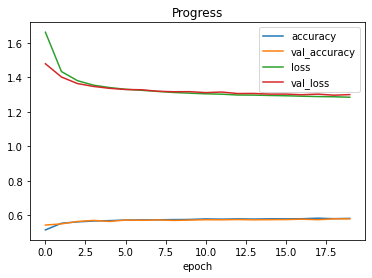

i=0 new_char: e (0.189) [best:  o (0.379), diff: 0.191, prob: 0.189, gap: 0.191]
i=1 new_char: o (0.048) [best:  n (0.197), diff: 0.149, prob: 0.009, gap: 0.340]
i=2 new_char: r (0.202) [best:  n (0.357), diff: 0.154, prob: 0.002, gap: 0.494]
i=3 new_char: g (0.045) [best:  i (0.273), diff: 0.228, prob: 0.000, gap: 0.722]
i=4 new_char: i (0.183) [best:  e (0.353), diff: 0.170, prob: 0.000, gap: 0.892]
i=5 new_char: a (0.277) [best:  e (0.378), diff: 0.101, prob: 0.000, gap: 0.993]
i=6 new_char: * (0.708) [best:  * (0.708), diff: 0.000, prob: 0.000, gap: 0.993]
jeorgia (probs: 0.000003, gap: 0.992959)
('jeorgia', {'probability': 2.9592518968677867e-06, 'gap': 0.9929592609405518})
i=0 new_char: m (0.135) [best:  m (0.135), diff: 0.000, prob: 0.135, gap: 0.000]
i=1 new_char: o (0.120) [best:  a (0.475), diff: 0.355, prob: 0.016, gap: 0.355]
i=2 new_char: r (0.621) [best:  r (0.621), diff: 0.000, prob: 0.010, gap: 0.355]
i=3 new_char: i (0.293) [best:  i (0.293), diff: 0.000, prob: 0.003, 

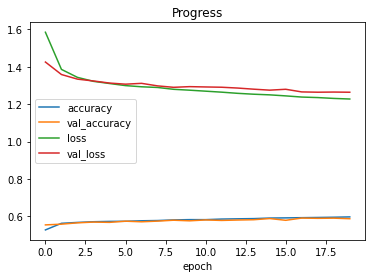

i=0 new_char: o (0.302) [best:  a (0.345), diff: 0.043, prob: 0.302, gap: 0.043]
i=1 new_char: e (0.053) [best:  l (0.191), diff: 0.138, prob: 0.016, gap: 0.181]
i=2 new_char: l (0.425) [best:  l (0.425), diff: 0.000, prob: 0.007, gap: 0.181]
i=3 new_char: l (0.445) [best:  l (0.445), diff: 0.000, prob: 0.003, gap: 0.181]
i=4 new_char: i (0.264) [best:  e (0.335), diff: 0.071, prob: 0.001, gap: 0.252]
i=5 new_char: a (0.130) [best:  n (0.358), diff: 0.227, prob: 0.000, gap: 0.479]
i=6 new_char: * (0.959) [best:  * (0.959), diff: 0.000, prob: 0.000, gap: 0.479]
joellia (probs: 0.000101, gap: 0.479413)
('joellia', {'probability': 0.00010058762783877048, 'gap': 0.47941267490386963})
i=0 new_char: o (0.015) [best:  m (0.103), diff: 0.088, prob: 0.015, gap: 0.088]
i=1 new_char: x (0.001) [best:  r (0.346), diff: 0.345, prob: 0.000, gap: 0.434]
i=2 new_char: y (0.078) [best:  i (0.470), diff: 0.393, prob: 0.000, gap: 0.826]
i=3 new_char: s (0.034) [best:  * (0.498), diff: 0.465, prob: 0.000,

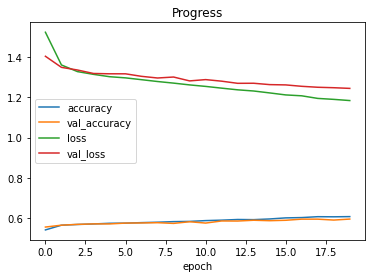

i=0 new_char: e (0.296) [best:  o (0.318), diff: 0.021, prob: 0.296, gap: 0.021]
i=1 new_char: e (0.066) [best:  n (0.264), diff: 0.197, prob: 0.020, gap: 0.219]
i=2 new_char: r (0.199) [best:  n (0.378), diff: 0.179, prob: 0.004, gap: 0.398]
i=3 new_char: * (0.048) [best:  i (0.549), diff: 0.501, prob: 0.000, gap: 0.900]
jeer (probs: 0.000186, gap: 0.899507)
('jeer', {'probability': 0.00018642508547249442, 'gap': 0.8995071649551392})
i=0 new_char: y (0.006) [best:  m (0.103), diff: 0.098, prob: 0.006, gap: 0.098]
i=1 new_char: a (0.132) [best:  n (0.267), diff: 0.135, prob: 0.001, gap: 0.233]
i=2 new_char: l (0.075) [best:  n (0.458), diff: 0.383, prob: 0.000, gap: 0.615]
i=3 new_char: e (0.159) [best:  l (0.411), diff: 0.252, prob: 0.000, gap: 0.868]
i=4 new_char: t (0.161) [best:  n (0.504), diff: 0.343, prob: 0.000, gap: 1.210]
i=5 new_char: t (0.223) [best:  a (0.411), diff: 0.187, prob: 0.000, gap: 1.398]
i=6 new_char: a (0.466) [best:  a (0.466), diff: 0.000, prob: 0.000, gap: 1

In [93]:
rnn_units = [32, 64, 128]
for rnn_unit in rnn_units:
    print('#'*30 + f" RNN Units: {rnn_unit} " + '#'*30)

    # Parameters changed for this run
    parameters["rnn_kind"] = "SimpleRNN" 
    parameters["optimizer"] = "adam"       
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["epochs_to_run"] = [20]
    parameters["history"] = {}
    parameters["rnn_units"] = rnn_unit

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    with catchtime() as t:
      for i in range(len(parameters["epochs_to_run"])):
          train_model(model, parameters)
          parameters["iter"] = i
    print(f"Execution time: {t():.4f} secs")
    
    plot_training_session(parameters, plots=["accuracy", "val_accuracy", "loss", "val_loss"])

    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))

## Try different optimizers

############################## Optimizer: adam ##############################
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_21 (SimpleRNN)   (None, 128)               20480     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 31)                3999      
                                                                 
Total params: 24,479
Trainable params: 24,479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1390/1390 [==============================] - 11s 7ms/step - loss: 1.5265 - accuracy: 0.5397 - val_loss: 1.3923 - val_accuracy: 0.5523
Epoch 2/20
1390/1390 [==============================] - 10s 7ms/step - loss: 1.3614 - accu

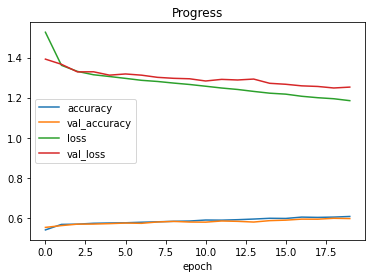

i=0 new_char: a (0.252) [best:  o (0.425), diff: 0.172, prob: 0.252, gap: 0.172]
i=1 new_char: l (0.047) [best:  n (0.438), diff: 0.390, prob: 0.012, gap: 0.562]
i=2 new_char: e (0.267) [best:  i (0.472), diff: 0.205, prob: 0.003, gap: 0.767]
i=3 new_char: e (0.226) [best:  e (0.226), diff: 0.000, prob: 0.001, gap: 0.767]
i=4 new_char: t (0.173) [best:  n (0.480), diff: 0.307, prob: 0.000, gap: 1.074]
i=5 new_char: t (0.217) [best:  a (0.314), diff: 0.097, prob: 0.000, gap: 1.172]
i=6 new_char: e (0.388) [best:  e (0.388), diff: 0.000, prob: 0.000, gap: 1.172]
i=7 new_char: a (0.008) [best:  * (0.832), diff: 0.824, prob: 0.000, gap: 1.996]
i=8 new_char: n (0.055) [best:  * (0.908), diff: 0.853, prob: 0.000, gap: 2.849]
i=9 new_char: n (0.742) [best:  n (0.742), diff: 0.000, prob: 0.000, gap: 2.849]
i=10 new_char: e (0.391) [best:  a (0.468), diff: 0.077, prob: 0.000, gap: 2.926]
i=11 new_char: * (0.840) [best:  * (0.840), diff: 0.000, prob: 0.000, gap: 2.926]
jaleetteanne (probs: 0.000

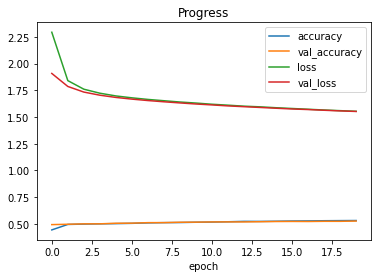

i=0 new_char: * (0.002) [best:  a (0.256), diff: 0.254, prob: 0.002, gap: 0.254]
j (probs: 0.001822, gap: 0.254213)
('j', {'probability': 0.0018220258643850684, 'gap': 0.25421342253685})
i=0 new_char: r (0.064) [best:  a (0.120), diff: 0.055, prob: 0.064, gap: 0.055]
i=1 new_char: e (0.114) [best:  a (0.217), diff: 0.103, prob: 0.007, gap: 0.158]
i=2 new_char: t (0.047) [best:  l (0.168), diff: 0.121, prob: 0.000, gap: 0.279]
i=3 new_char: h (0.030) [best:  i (0.127), diff: 0.096, prob: 0.000, gap: 0.376]
i=4 new_char: y (0.040) [best:  a (0.227), diff: 0.187, prob: 0.000, gap: 0.563]
i=5 new_char: i (0.030) [best:  * (0.639), diff: 0.609, prob: 0.000, gap: 1.172]
i=6 new_char: o (0.004) [best:  * (0.559), diff: 0.555, prob: 0.000, gap: 1.728]
i=7 new_char: s (0.008) [best:  * (0.422), diff: 0.414, prob: 0.000, gap: 2.141]
i=8 new_char: e (0.116) [best:  * (0.430), diff: 0.315, prob: 0.000, gap: 2.456]
i=9 new_char: e (0.071) [best:  * (0.611), diff: 0.540, prob: 0.000, gap: 2.996]
i=1

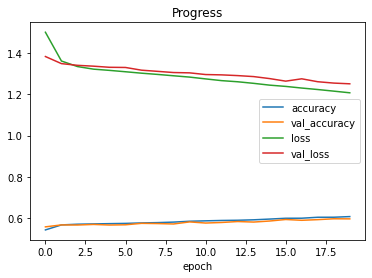

i=0 new_char: o (0.378) [best:  o (0.378), diff: 0.000, prob: 0.378, gap: 0.000]
i=1 new_char: r (0.121) [best:  l (0.256), diff: 0.135, prob: 0.046, gap: 0.135]
i=2 new_char: r (0.022) [best:  i (0.418), diff: 0.396, prob: 0.001, gap: 0.531]
i=3 new_char: e (0.224) [best:  i (0.425), diff: 0.201, prob: 0.000, gap: 0.731]
i=4 new_char: * (0.416) [best:  * (0.416), diff: 0.000, prob: 0.000, gap: 0.731]
jorre (probs: 0.000094, gap: 0.731345)
('jorre', {'probability': 9.388999194920837e-05, 'gap': 0.7313448935747147})
i=0 new_char: k (0.041) [best:  m (0.121), diff: 0.080, prob: 0.041, gap: 0.080]
i=1 new_char: o (0.098) [best:  a (0.412), diff: 0.315, prob: 0.004, gap: 0.395]
i=2 new_char: r (0.525) [best:  r (0.525), diff: 0.000, prob: 0.002, gap: 0.395]
i=3 new_char: l (0.076) [best:  e (0.315), diff: 0.239, prob: 0.000, gap: 0.634]
i=4 new_char: e (0.376) [best:  e (0.376), diff: 0.000, prob: 0.000, gap: 0.634]
i=5 new_char: n (0.110) [best:  e (0.381), diff: 0.271, prob: 0.000, gap: 

In [95]:
optimizers = ['adam', 'sgd', 'rmsprop']
for optimizer in optimizers:
    print('#'*30 + f" Optimizer: {optimizer} " + '#'*30)

    # Parameters changed for this run
    parameters["optimizer"] = optimizer      
    parameters["rnn_kind"] = "SimpleRNN"      
    parameters["iter"] = 0
    parameters["total_epochs"] = 0
    parameters["epochs_to_run"] = [20]
    parameters["history"] = {}
    parameters["rnn_units"] = rnn_unit

    model = create_model(parameters)
    compile_model(
        model,
        parameters
    )
    
    with catchtime() as t:
      for i in range(len(parameters["epochs_to_run"])):
          train_model(model, parameters)
          parameters["iter"] = i
    print(f"Execution time: {t():.4f} secs")
    
    plot_training_session(parameters, plots=["accuracy", "val_accuracy", "loss", "val_loss"])

    print(generate_name(model, parameters, start_char = 'j'))
    print(generate_name(model, parameters))